In [1]:
import os
from pathlib import Path
from itertools import product
from tqdm import tqdm, trange
import numpy as np

import torch

In [2]:
from classes import device
from classes import Board
from classes import TicTacToeNet as AI
from classes import Agent

Using CUDA


In [3]:
# Notebook configuration: change these to control experiment size
# Number of agents per generation
GENERATION_SIZE = 10
# Number of training epochs / generations to run/save/load
NUM_EPOCHS = 10

In [4]:
def play_game(agent1, agent2):
    board = Board()
    current_agent = agent1
    game_history = []  # Track states, moves, and agents

    while True:
        # Record state before move
        state = board.get_boards()

        # Select and make move
        move = current_agent.sel_move(board)
        game_history.append({
            'state': state,
            'move': move,
            'agent': 0 if current_agent == agent1 else 1
        })

        board.make_move(move)
        winner = board.check_win()

        if winner is not None:
            return game_history, winner

        current_agent = agent2 if current_agent == agent1 else agent1

In [5]:
agents = [Agent(AI()) for _ in range(GENERATION_SIZE)]

In [6]:
def print_board(board_state):
    """Print a formatted board to console with unicode characters"""
    symbols = {0: ' ', 1: 'X', -1: 'O'}

    # Top border
    print("┌───┬───┬───┐")

    for r in range(3):
        # Cell content
        row_str = "│"
        for c in range(3):
            row_str += f" {symbols[board_state[r, c]]} │"
        print(row_str)

        # Middle or bottom border
        if r < 2:
            print("├───┼───┼───┤")
        else:
            print("└───┴───┴───┘")

In [7]:
def draw_game_history(game_history, winner):
    """Print the progression of a game from game_history"""

    board_state = np.zeros((3, 3), dtype=np.int8)

    # Print initial empty board
    print("Initial Board:")
    print_board(board_state)
    print()

    # Process each move
    for idx, move_data in enumerate(game_history):
        move = move_data['move']
        agent = move_data['agent']

        # Place the move on board
        row, col = divmod(move, 3)
        board_state[row, col] = 1 if agent == 0 else -1

        # Print board at this step
        print(f"Move {idx + 1} (Agent {agent} - {'X' if agent == 0 else 'O'}):")
        print_board(board_state)
        print()

    # Print result
    if winner == 1:
        result = "Agent 0 (X) wins!"
    elif winner == -1:
        result = "Agent 1 (O) wins!"
    else:
        result = "Draw!"
    print(f"Game Result: {result}")

In [8]:
# Example: Play a game and visualize it
game_history, winner = play_game(agents[0], agents[1])
draw_game_history(game_history, winner)


Initial Board:
┌───┬───┬───┐
│   │   │   │
├───┼───┼───┤
│   │   │   │
├───┼───┼───┤
│   │   │   │
└───┴───┴───┘

Move 1 (Agent 0 - X):
┌───┬───┬───┐
│   │   │   │
├───┼───┼───┤
│ X │   │   │
├───┼───┼───┤
│   │   │   │
└───┴───┴───┘

Move 2 (Agent 1 - O):
┌───┬───┬───┐
│ O │   │   │
├───┼───┼───┤
│ X │   │   │
├───┼───┼───┤
│   │   │   │
└───┴───┴───┘

Move 3 (Agent 0 - X):
┌───┬───┬───┐
│ O │   │   │
├───┼───┼───┤
│ X │   │   │
├───┼───┼───┤
│   │ X │   │
└───┴───┴───┘

Move 4 (Agent 1 - O):
┌───┬───┬───┐
│ O │   │   │
├───┼───┼───┤
│ X │   │   │
├───┼───┼───┤
│   │ X │ O │
└───┴───┴───┘

Move 5 (Agent 0 - X):
┌───┬───┬───┐
│ O │   │   │
├───┼───┼───┤
│ X │   │ X │
├───┼───┼───┤
│   │ X │ O │
└───┴───┴───┘

Move 6 (Agent 1 - O):
┌───┬───┬───┐
│ O │ O │   │
├───┼───┼───┤
│ X │   │ X │
├───┼───┼───┤
│   │ X │ O │
└───┴───┴───┘

Move 7 (Agent 0 - X):
┌───┬───┬───┐
│ O │ O │   │
├───┼───┼───┤
│ X │   │ X │
├───┼───┼───┤
│ X │ X │ O │
└───┴───┴───┘

Move 8 (Agent 1 - O):
┌───┬───┬───┐
│ O

In [9]:
# Training loop: all agents play against each other (round robin) with reinforcement learning
num_epochs = NUM_EPOCHS

# Track stats for each agent [wins, losses, draws]
stats = [[0, 0, 0] for _ in range(len(agents))]

for epoch in trange(num_epochs, desc="Epochs"):
    # Create all ordered pairings: each agent plays every other agent
    pairings = [(i, j) for i in range(len(agents)) for j in range(len(agents)) if i != j]

    # Play all games in this epoch
    for agent_i, agent_j in pairings:
        # Agent i plays as X (player 1), agent j plays as O (player 2)
        game_history, winner = play_game(agents[agent_i], agents[agent_j])

        if winner == 1:
            outcome_i, outcome_j = 1, -1  # Agent i wins, agent j loses
            stats[agent_i][0] += 1  # Agent i wins (played first)
            stats[agent_j][1] += 1  # Agent j loses (played second)
        elif winner == -1:
            outcome_i, outcome_j = -1, 1  # Agent i loses, agent j wins
            stats[agent_i][1] += 1  # Agent i loses (played first)
            stats[agent_j][0] += 1  # Agent j wins (played second)
        else:
            outcome_i, outcome_j = 0, 0  # Draw
            stats[agent_i][2] += 1  # Draw
            stats[agent_j][2] += 1  # Draw

        # Train both agents on the game
        agents[agent_i].train_on_game(game_history, outcome_i)
        agents[agent_j].train_on_game(game_history, outcome_j)

    # Save models for this generation
    gen_folder = Path(f"models/generation_{epoch}")
    gen_folder.mkdir(parents=True, exist_ok=True)

    for idx, agent in enumerate(agents):
        model_path = gen_folder / f"agent_{idx}.pt"
        agent.save_model(model_path)

# Print standings from final epoch
print("\nFinal Epoch Standings:")
print(f"{'Agent':<8} {'Win %':<10} {'Draw %':<10} {'Loss %':<10}")
print("-" * 38)

for idx, (wins, losses, draws) in enumerate(stats):
    total = wins + losses + draws
    win_pct = (wins / total * 100) if total > 0 else 0
    draw_pct = (draws / total * 100) if total > 0 else 0
    loss_pct = (losses / total * 100) if total > 0 else 0
    print(f"Agent {idx:<2} {win_pct:>6.1f}% {draw_pct:>6.1f}% {loss_pct:>6.1f}%")


Epochs: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Final Epoch Standings:
Agent    Win %      Draw %     Loss %    
--------------------------------------
Agent 0    57.2%   10.0%   32.8%
Agent 1    46.7%   11.7%   41.7%
Agent 2    41.7%   10.6%   47.8%
Agent 3    42.8%    8.3%   48.9%
Agent 4    41.7%    7.2%   51.1%
Agent 5    51.1%    9.4%   39.4%
Agent 6    50.6%    6.7%   42.8%
Agent 7    36.7%   12.8%   50.6%
Agent 8    39.4%   11.1%   49.4%
Agent 9    43.3%   10.0%   46.7%


In [10]:
# Load agents from first and last epochs
agents_gen0 = []
agents_gen4 = []

for i in range(GENERATION_SIZE):
    # Load generation 0 agents
    model0 = AI()
    model0.load_state_dict(torch.load(f"models/generation_0/agent_{i}.pt", weights_only=True))
    agents_gen0.append(Agent(model0))

    # Load generation 4 agents
    model4 = AI()
    model4.load_state_dict(torch.load(f"models/generation_{NUM_EPOCHS-1}/agent_{i}.pt", weights_only=True))
    agents_gen4.append(Agent(model4))

# Play all games: each gen_4 agent vs each gen_0 agent
# Track stats for gen_4 agents
gen4_stats = [[0, 0, 0] for _ in range(GENERATION_SIZE)]  # [wins, losses, draws]

# Create pairings: each gen_4 agent plays each gen_0 agent
pairings = [(i, j) for i in range(GENERATION_SIZE) for j in range(GENERATION_SIZE)]

for gen4_idx, gen0_idx in tqdm(pairings, desc="Generation 4 vs Generation 0"):
    game_history, winner = play_game(agents_gen4[gen4_idx], agents_gen0[gen0_idx])

    if winner == 1:
        gen4_stats[gen4_idx][0] += 1  # Gen4 agent wins
    elif winner == -1:
        gen4_stats[gen4_idx][1] += 1  # Gen4 agent loses
    else:
        gen4_stats[gen4_idx][2] += 1  # Draw

# Rank agents: first by loss percentage (ascending), then by draw percentage (ascending)
gen4_rankings = []
for idx, (wins, losses, draws) in enumerate(gen4_stats):
    total = wins + losses + draws
    loss_pct = (losses / total * 100) if total > 0 else 0
    draw_pct = (draws / total * 100) if total > 0 else 0
    win_pct = (wins / total * 100) if total > 0 else 0
    gen4_rankings.append((idx, win_pct, loss_pct, draw_pct, wins, losses, draws))

# Sort by loss percentage (ascending), then by draw percentage (ascending)
gen4_rankings.sort(key=lambda x: (x[2], x[3]))

print(f"\nGeneration {NUM_EPOCHS-1} vs Generation 0 Rankings:")
print(f"{'Rank':<6} {'Agent':<8} {'Win %':<10} {'Loss %':<10} {'Draw %':<10} {'Record':<15}")
print("-" * 59)

for rank, (idx, win_pct, loss_pct, draw_pct, wins, losses, draws) in enumerate(gen4_rankings, 1):
    print(f"{rank:<6} Agent {idx:<2} {win_pct:>6.1f}%    {loss_pct:>6.1f}%     {draw_pct:>6.1f}%     {wins}-{losses}-{draws}")


Generation 4 vs Generation 0: 100%|██████████| 100/100 [00:00<00:00, 221.37it/s]


Generation 9 vs Generation 0 Rankings:
Rank   Agent    Win %      Loss %     Draw %     Record         
-----------------------------------------------------------
1      Agent 0    70.0%      30.0%        0.0%     7-3-0
2      Agent 1    60.0%      30.0%       10.0%     6-3-1
3      Agent 6    60.0%      30.0%       10.0%     6-3-1
4      Agent 9    50.0%      30.0%       20.0%     5-3-2
5      Agent 5    50.0%      40.0%       10.0%     5-4-1
6      Agent 7    50.0%      40.0%       10.0%     5-4-1
7      Agent 3    40.0%      40.0%       20.0%     4-4-2
8      Agent 8    40.0%      40.0%       20.0%     4-4-2
9      Agent 4    30.0%      40.0%       30.0%     3-4-3
10     Agent 2    20.0%      60.0%       20.0%     2-6-2


100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


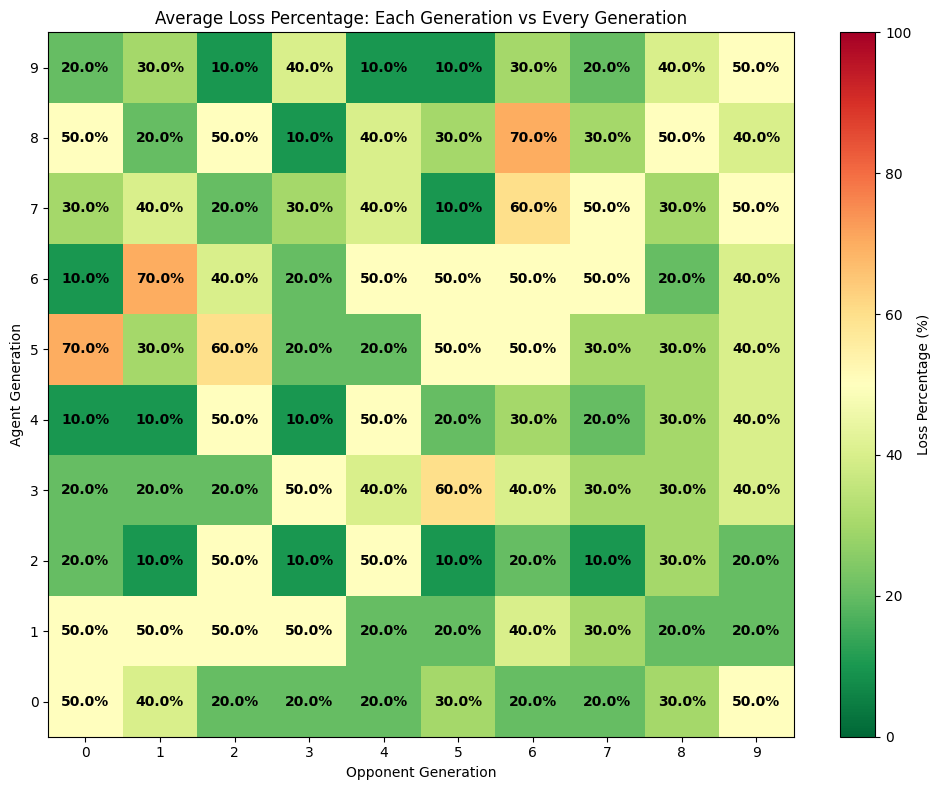

In [11]:
import matplotlib.pyplot as plt

# Load all agents from all generations
all_agents = {}
for gen in range(NUM_EPOCHS):
    all_agents[gen] = []
    for i in range(GENERATION_SIZE):
        model = AI()
        model.load_state_dict(torch.load(f"models/generation_{gen}/agent_{i}.pt", weights_only=True))
        all_agents[gen].append(Agent(model))

# Create a matrix to store win percentages (generations x generations)
win_matrix = np.zeros((NUM_EPOCHS, NUM_EPOCHS))

# Play each corresponding agent pair across all generations
for gen_a in trange(NUM_EPOCHS):
    for gen_b in range(NUM_EPOCHS):
        if gen_a == gen_b:
            # Agents playing themselves (skip or set to 50%)
            win_matrix[gen_a][gen_b] = 50.0
        else:
            # Each agent i from gen_a plays against agent i from gen_b
            losses = 0
            total_games = 0

            for agent_idx in range(GENERATION_SIZE):
                game_history, winner = play_game(all_agents[gen_a][agent_idx], all_agents[gen_b][agent_idx])

                if winner == -1:
                    losses += 1

                total_games += 1

            win_matrix[gen_a][gen_b] = (losses / total_games * 100) if total_games > 0 else 0

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.pcolormesh(win_matrix, cmap='RdYlGn_r', vmin=0, vmax=100, shading='auto')
plt.colorbar(label='Loss Percentage (%)')
plt.xlabel('Opponent Generation')
plt.ylabel('Agent Generation')
plt.title('Average Loss Percentage: Each Generation vs Every Generation')
plt.xticks(np.arange(NUM_EPOCHS) + 0.5, range(NUM_EPOCHS))
plt.yticks(np.arange(NUM_EPOCHS) + 0.5, range(NUM_EPOCHS))

# Add text annotations
if NUM_EPOCHS <= 10:  # Only add text if the matrix is small enough to read
    for i in range(NUM_EPOCHS):
        for j in range(NUM_EPOCHS):
            plt.text(j + 0.5, i + 0.5, f'{win_matrix[i, j]:.1f}%',
                    ha='center', va='center', color='black', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()
